In [1]:
# compare default ODIAC and EDGAR5, and apply seasonal cycle

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["font.size"] = 12

import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from util.functions import area_latlon
from util.gamap_colormap import WhGrYlRd

In [4]:
input_dir = '/home/msadiq/Desktop/co2/emissions/'

In [5]:
ds_GC = xr.open_dataset(input_dir + 'GC/nc/ODIAC_CO2.monthly.generic.1x1.nc')
ds_EDGAR = xr.open_dataset(input_dir + 'EDGAR/nc/v50_CO2_excl_short-cycle_org_C_2014.0.1x0.1.nc')

In [6]:
ds_GC['CO2'][168:180,:,:]

<xarray.DataArray 'CO2' (time: 12, lat: 180, lon: 360)>
[777600 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time     (time) datetime64[ns] 2014-01-01 2014-02-01 ... 2014-12-01
Attributes:
    long_name:  ODIAC Fossil Fuel CO2 from Tom Oda
    units:      kg/m2/s

In [7]:
ds_EDGAR['emi_co2']

<xarray.DataArray 'emi_co2' (lat: 1800, lon: 3600)>
[6480000 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
  * lon      (lon) float32 -179.95 -179.85 -179.75 ... 179.75 179.85 179.95
Attributes:
    standard_name:  tendency_of_atmosphere_mass_content_of_carbon_dioxide_due...
    long_name:      Emissions of CO2 - 
    units:          kg m-2 s-1
    cell_method:    time: mean (interval: 1 year, 365 days)
    total_emi_co2:     3.63274e+013 kg/year
    comment:         (see http://edgar.jrc.ec.europa.eu/methodology.php#12sou...

In [11]:
# 1, calculate annual total emission (Tg/yr) and compare
# need function to compute grid area

# 1.1, EDGAR total
data = ds_EDGAR['emi_co2'].copy()
lat_res = 0.1
lon_res = 0.1

for ilat, lat in enumerate(data.lat):
    area_tmp = area_latlon(lat1 = lat, 
                           lon1 = data.lon[10].values, 
                           lat2 = lat + lat_res, 
                           lon2 = data.lon[10].values + lon_res)
    data[ilat,:] = data[ilat,:] * area_tmp *3600*24*365*1e6 # unit: kgCO2/yr
annual_edgar = data.copy()
total_edgar = data.sum() # kgCO2/year, same as data description
print('Annual total ffCO2 emission (GtCO2/yr): ', total_edgar.values*1e-12) # GtCO2/yr
print('Annual total ffCO2 emission (GtC/yr): ', total_edgar.values*1e-12*12/44) # GtCO2/yr

Annual total ffCO2 emission (GtCO2/yr):  36.306847531007996
Annual total ffCO2 emission (GtC/yr):  9.901867508456725


In [8]:
# 1.2, GC total
data = ds_GC['CO2'][168:180,:,:].copy()
lat_res = 1
lon_res = 1
days_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]

for ilat, lat in enumerate(data.lat):
    for imonth in range(12):
        area_tmp = area_latlon(lat1 = lat, 
                           lon1 = data.lon[10].values, 
                           lat2 = lat + lat_res, 
                           lon2 = data.lon[10].values + lon_res)
        data[imonth,ilat,:] = data[imonth,ilat,:] * area_tmp *days_in_month[imonth] *3600*24*1e6 # unit: kgCO2/yr
annual_gc = data.sum(dim='time')
total_gc = data.sum() # kgCO2/year, same as data description
total_gc*1e-12 # GtCO2/yr

<xarray.DataArray 'CO2' ()>
array(35.16872733)

In [9]:
print('difference: ', 100*(total_edgar-total_gc)/total_gc, '%')

difference:  <xarray.DataArray ()>
array(3.23617112) %


In [10]:
# 2, regrid EDGAR to 1x1 degree res and compare with GC
ds_EDGAR_1degree = xr.open_dataset(input_dir + 
                                   'EDGAR/nc/EDGAR_2018_1x1.nc')
# 2.1 EDGAR annual total from 1 degree
data = ds_EDGAR_1degree['emi_co2'].copy() # unit: kg/m2/s
lat_res = 1
lon_res = 1

for ilat, lat in enumerate(data.lat):
    area_tmp = area_latlon(lat1 = lat, 
                           lon1 = data.lon[10].values, 
                           lat2 = lat + lat_res, 
                           lon2 = data.lon[10].values + lon_res)
    data[ilat,:] = data[ilat,:] * area_tmp *3600*24*365*1e6 # unit: kgCO2/yr
annual_edgar = data.copy()
total_edgar = data.sum() # kgCO2/year, same as data description
total_edgar*1e-12 # GtCO2/yr

<xarray.DataArray 'emi_co2' ()>
array(37.86509019)

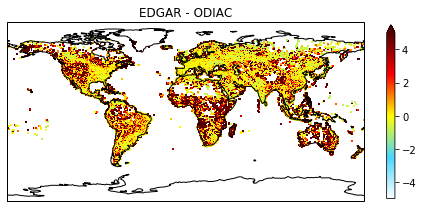

In [11]:
diff = (annual_edgar - annual_gc)/annual_gc
#diff = annual_edgar/annual_gc
#diff = diff*1e-9 # MtCO2/yr

fig = plt.figure(figsize=[8, 4])
proj=ccrs.PlateCarree()
ax = plt.subplot(111, projection=proj)
ax.coastlines()
diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap = WhGrYlRd, vmax = 5, cbar_kwargs={'shrink': 0.8, 'label': ''})
ax.set_title('EDGAR - ODIAC');

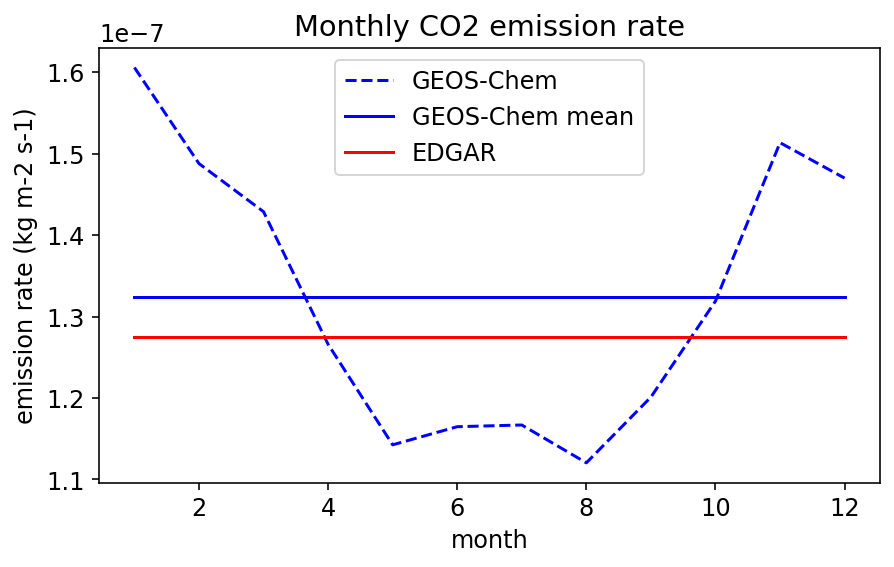

In [42]:
# 3, pick a grid cell and compare seasonal cycle between the two
loc_lat = 48
loc_lon = 2

one_edgar = ds_EDGAR_1degree['emi_co2'].sel(lat=loc_lat,lon=loc_lon, method='nearest')
one_gc    = ds_GC['CO2'][168:180,:,:].sel(lat=loc_lat,lon=loc_lon, method='nearest')

fig = plt.figure(figsize=[7, 4])
plt.title('Monthly CO2 emission rate')
plt.plot(range(1,13), one_gc, 'b--', label = 'GEOS-Chem')
plt.plot(range(1,13), np.repeat(one_gc.mean().values,12), 'b', label = 'GEOS-Chem mean')
plt.plot(range(1,13), np.repeat(one_edgar.values,12), 'r', label = 'EDGAR')
plt.ylabel('emission rate (kg m-2 s-1)')
plt.xlabel('month')
plt.legend()

fig.savefig(input_dir + '/comparison/EDGAR_monthly.png', dpi=300)

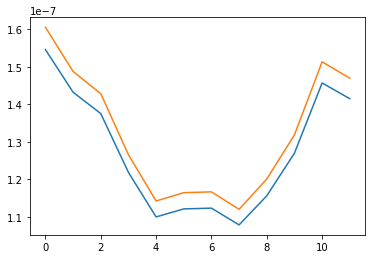

In [13]:
scale_f = one_gc / one_gc.mean()
scaled_edgar = scale_f * one_edgar
plt.plot(scaled_edgar)
plt.plot(one_gc)

In [14]:
# 4, add seasonal scaling factor from GC to EDGAR dataset
empty_edgar_12 = ds_GC['CO2'][168:180,:,:].copy()
empty_edgar_12.values = np.zeros(12*180*360).reshape(12,180,360)
empty_edgar_12.attrs['long_name'] = 'EDGAR fossil fuel CO2 from Mehliyar Sadiq'

In [15]:
for ilon in range(360):
    for ilat in range(180):
        one_edgar = ds_EDGAR_1degree['emi_co2'].isel(lat = ilat, lon = ilon)
        one_gc    = ds_GC['CO2'][168:180,:,:].isel(lat=ilat,lon=ilon)
        scale_f = one_gc / one_gc.mean()
        empty_edgar_12[:,ilat,ilon] = scale_f * one_edgar

KeyboardInterrupt: 

In [ ]:
tmp = empty_edgar_12.sel(lat=loc_lat,lon=loc_lon, method='nearest')
plt.plot(tmp)

In [ ]:
edgar_monthly = empty_edgar_12.to_dataset(name='emi_co2')
print(edgar_monthly)
edgar_monthly.to_netcdf(input_dir+'EDGAR/nc/EDGAR_monthly_2018_1x1.nc')